## High Frequncy Trading course work

## Introduction

This notebook is divided into 2 sections. In Part 1, it details about the data exploration of histortical intraday google equity data microstructure like midprice and microprice, then order imbalance, stamped every 100 millisecond of the trading day (26th Nov 2014). It also details about the implication of price movement by order imbalance 

In part 2, it also explores the optimal trading strategy by defining optimal speed to trade at and inventory along for liquidating 500,000 shares in 1 day. 

## Import all the necessay packages

In [274]:
# import packages

import scipy.io as sio  # for loading matlab data

import numpy as np      # for numerical libs

import pandas as pd  # for data storage and exploration

from matplotlib.ticker import FuncFormatter # for custom bar plot labels

import matplotlib.pyplot as plt  # for plotting

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import import_ipynb # to import liquidation price package
import Liquidation_Permanent_Price_Impact_helper as lppi_helpers

# PART 1

## Load Data

In [153]:
google = sio.loadmat('GOOG_20141126.mat')

Trading starts from 9.30AM and ends at 4PM with total of 6.5 hours. In our data, event time is in timestamp(ms) so we need to convert that to start period value (0) . This can be obtained by subtracting  3600000 with trade starting time (9.30AM) and then mutiply with 0.001 to convert from ms to seconds.  

t = Event trade time
bid = Buy price
ask = sell price
bidvol = Buy volume
askvol = Ask volume
Mo = Market Order
dt = time steps 

In [168]:
LOB=google['LOB']

t = (np.array((LOB['EventTime'][0][0][:,0]))-3600000*9.5)*1e-3
bid = np.array(LOB['BuyPrice'][0][0]*1e-4)
bidvol = np.array(LOB['BuyVolume'][0][0]*1.0)
ask = np.array(LOB['SellPrice'][0][0]*1e-4)
askvol = np.array(LOB['SellVolume'][0][0]*1.0)
MO=np.array(LOB['MO'][0][0]*1.0)
dt = t[1]-t[0]

## Midprice

Midprice is the arithmetic average of best ask and best bid price as mentioned in below formula. 


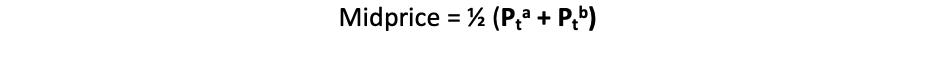

In [155]:
midprice_np = 0.5*(bid[:,0]+ask[:,0])

In [156]:
midprice = pd.DataFrame(midprice_np)

Below satistical information of price shows that we have data for each seconds for total of 6.5hours (234000 seconds)



with trading price ranging between  $ 537.07    to  $ 541.42 



,average mid price of $ 538.82  and price variation of  0.69 from the mean. 


In this 50%  of the trades are traded at $ 538.95 


and 75% of the trades are executed at $ 539.25  

In [157]:
midprice.describe()

,0
count,234000.000000
mean,538.829913
std,0.690640
min,537.070000
25%,538.630000
50%,538.955000
75%,539.255000
max,541.425000


## Histogram of mid price

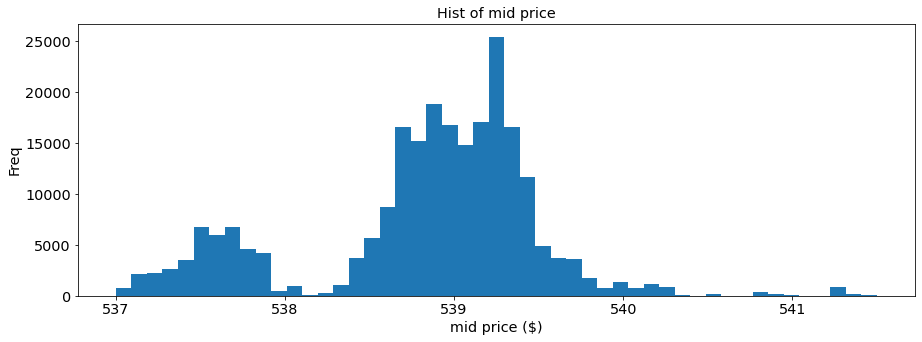

In [158]:
plt.hist(midprice, bins=np.linspace(537, 541.5, num=50)) 
plt.title("Hist of mid price")
plt.xlabel('mid price ($)')
plt.ylabel('Freq')
plt.show()

In [159]:
midprice_np[200100]

537.47

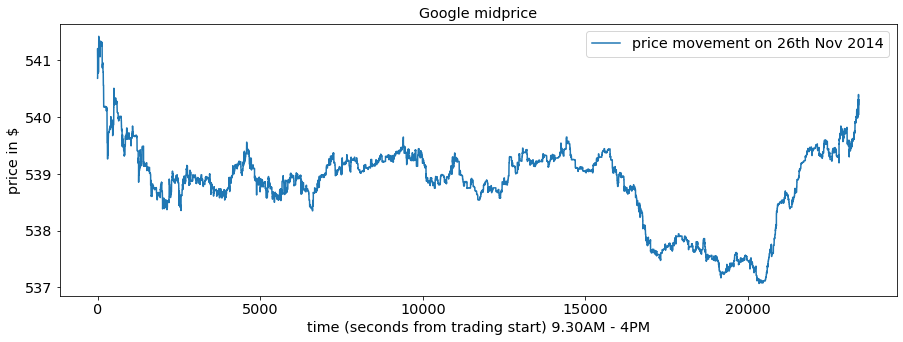

In [160]:
plt.plot(t, midprice_np)
plt.title('Google midprice')
plt.ylabel('price in $')
plt.xlabel('time (seconds from trading start) 9.30AM - 4PM')
plt.legend(['price movement on 26th Nov 2014'])
plt.show()

## Microprice 

Microprice is weighted average of the best bid and best ask price based the volume on posted for bid and ask

In [161]:
microprice= (bid[:,0]*askvol[:,0]+ ask[:,0]*bidvol[:,0])/(bidvol[:,0]+askvol[:,0])

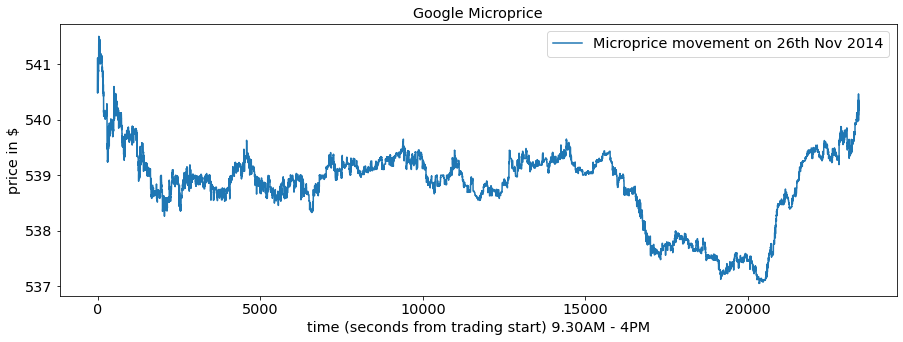

In [162]:
plt.plot(t, microprice)
plt.title('Google Microprice')
plt.ylabel('price in $')
plt.xlabel('time (seconds from trading start) 9.30AM - 4PM')
plt.legend(['Microprice movement on 26th Nov 2014'])
plt.show()

Below statistics shows how the micrprice varies with its average, min and maximum price. 

In [163]:
microprice_pd = pd.DataFrame(microprice)
microprice_pd.describe()

,0
count,234000.000000
mean,538.822431
std,0.688478
min,537.046000
25%,538.625455
50%,538.970000
75%,539.249801
max,541.504242


Difference between Micro and Mid price 

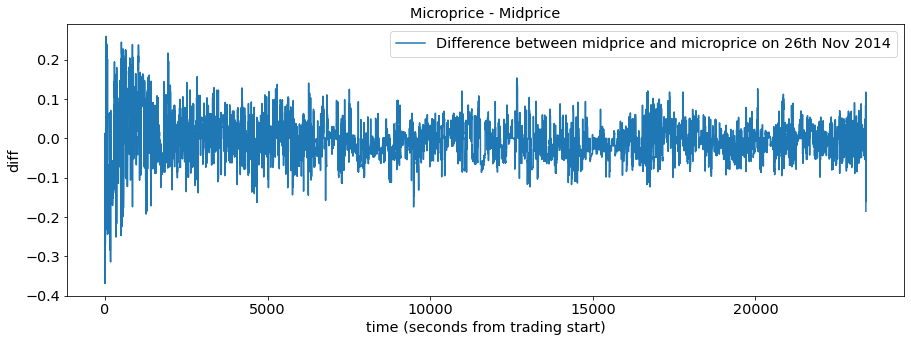

In [88]:
plt.plot(t, microprice-midprice_np)
plt.title('Microprice - Midprice')
plt.ylabel('diff')
plt.xlabel('time (seconds from trading start)')
plt.legend(['Difference between midprice and microprice on 26th Nov 2014'])
plt.show()

The differnce between micro price and mid price is high around 100 to 1000 ms and  it started to fluctuate between (-0.175 to +1.75) 

## Spread 

Spread is the difference between ask and bid price. Below chart shows that there's spike only during start of the trading time (9.30AM) to 1.1 and it moved back to 0.1 - 0.2 range

In [89]:
spread = ask[:,0]-bid[:,0]

Ask and bid price at 1s 

In [90]:
ask[1,0], bid[1,0]

(541.25, 540.12)

Ask and bid price after 2.7hrs

In [91]:
ask[10000,0], bid [10000,0]

(539.74, 539.51)

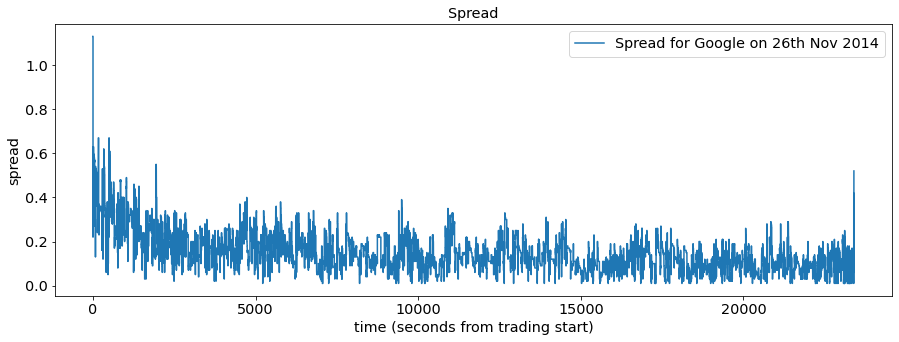

In [15]:
plt.plot(t,spread)
plt.title('Spread')
plt.ylabel('spread')
plt.xlabel('time (seconds from trading start)')
plt.legend(['Spread for Google on 26th Nov 2014'])
plt.show()

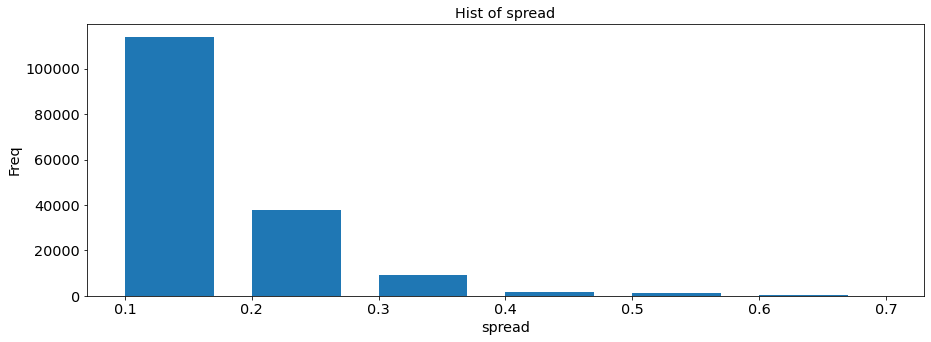

In [16]:
plt.hist(spread,bins=[0.1,0.2,0.3,0.4,0.5,0.6,0.7], width=0.07,align='mid') 
plt.title("Hist of spread")
plt.xlabel(r'spread')
plt.ylabel('Freq')
plt.show()

Histogram help to understand what is the spread most of the time. As per above bin spread is  around 0.15 and 0.25 with few around  0.3 - 0.6

## Volume Order Imbalance

In [94]:
rho_voi = np.array(bidvol[:,0]-askvol[:,0],ndmin=2).T
             

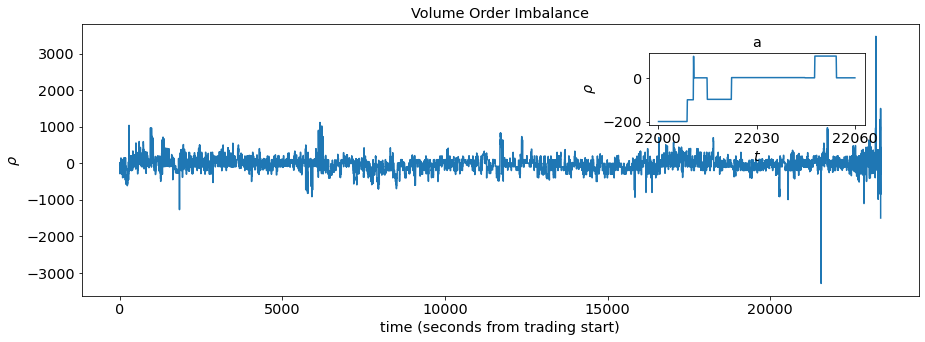

In [95]:
plt.plot(t, rho_voi)
plt.title('Volume Order Imbalance')
plt.ylabel(r'$\rho$')
plt.xlabel('time (seconds from trading start)')

a = plt.axes([.65, .6, .2, .2])
idx = (t>22000) & (t<=22000+60)
plt.plot( t[idx], rho_voi[idx])
plt.title('a')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$t$')
plt.xticks([22000,22030,22060])

plt.show()

## Volume Order Imbalance Ratio

In [96]:
rho = np.array((bidvol[:,0] - askvol[:,0])/(bidvol[:,0] + askvol[:,0]),ndmin=2).T

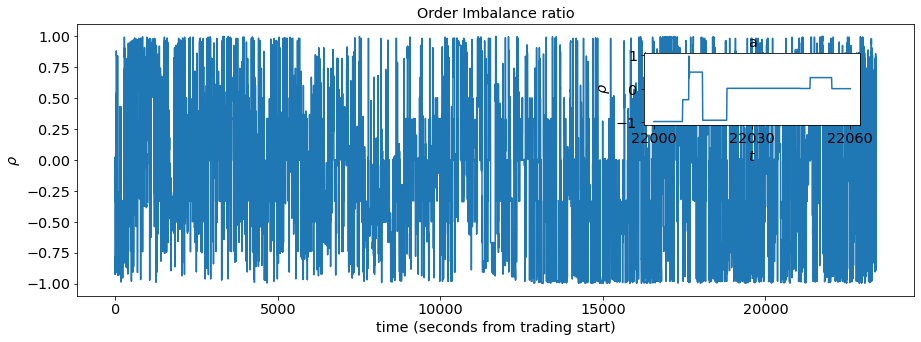

In [97]:
plt.plot(t, rho)
plt.title('Order Imbalance ratio')
plt.ylabel(r'$\rho$')
plt.xlabel('time (seconds from trading start)')

a = plt.axes([.65, .6, .2, .2])
idx = (t>22000) & (t<=22000+60)
plt.plot( t[idx], rho[idx])
plt.title('a')
plt.ylabel(r'$\rho$')
plt.xlabel(r'$t$')
plt.xticks([22000,22030,22060])

plt.show()

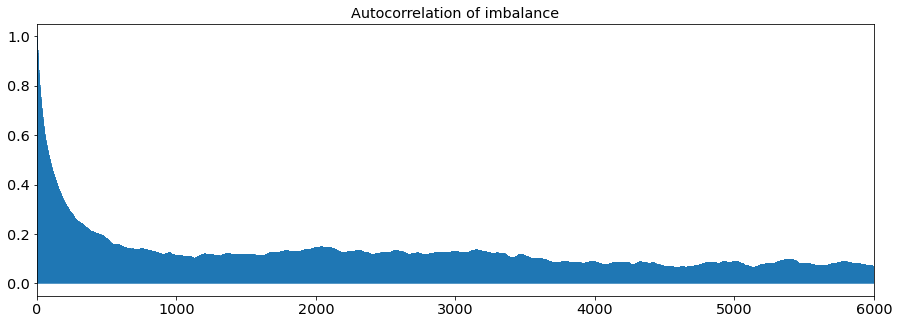

In [98]:
plt.acorr(rho[:,0]-np.mean(rho[:,0]),maxlags=6000)  # maximum one minute 
plt.title('Autocorrelation of imbalance')
plt.xlim([0,6000])
plt.show()


order imbalance tends to mean-revert, and has siginificant auto-correlation.

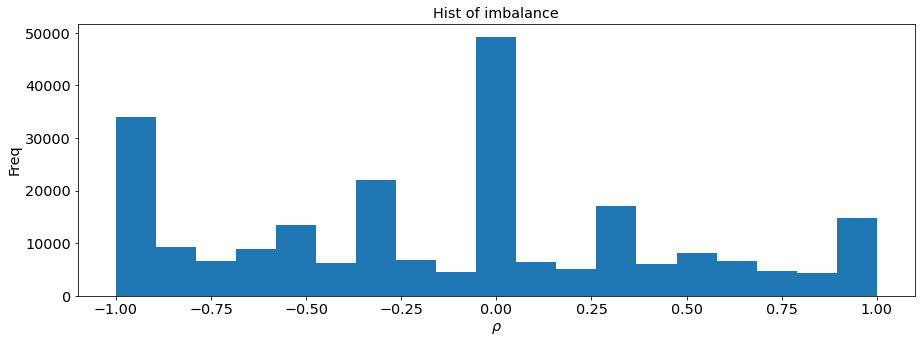

In [23]:
plt.hist(rho, bins=np.linspace(-1, 1, num=20)) 
plt.title("Hist of imbalance")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

## Volume Imbalance at times of Market Orders

Now lets look at the behaviour of order imbalance an instant before market order buys or sells arrive.

In [173]:
rho_MO = (MO[:,3]-MO[:,4])/(MO[:,3]+MO[:,4])

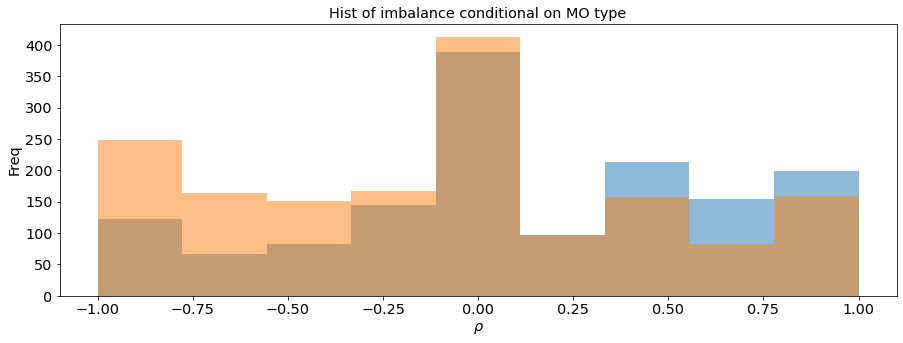

In [174]:
plt.hist(rho_MO[MO[:,7]==-1], bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.hist(rho_MO[MO[:,7]==+1], bins=np.linspace(-1, 1, num=10),alpha=0.5)
plt.title("Hist of imbalance conditional on MO type")
plt.xlabel(r'$\rho$')
plt.ylabel('Freq')
plt.show()

The above histogram shows that buy orders tend to arrive when the order imbalance is tilted to the buy side, while sell orders tend to arrive when the order imbalance is tilted to the sell side.

# PART 2 

In [271]:
# parameters
S0 = 541 # Stock trading price
Q = 500000 #Initial number of stocks 500k 
T = 1; # Liquidate within 1 day
N = 46800;    #Number of trading times
dt = T / N  # Number of trading steps
t = np.arange(0, T + dt, dt) #list of time steps till T+dt
sigma = 0.50; #volatility in price movement

k = 0.008 # Temporary price impact
b = 0.007 # Permanent price impact

k_2 = 0.0003 # Temporary price impact
b_2 = 0.0004 # Permanent price impact

tau = T - t 
tt = np.arange(0, 1 + 1 / 10, 1 / 10)

myphi = np.array([90e-10, 0.003, 0.10, 0.7]) #setting different inventory penalty
symb = np.array(["o", "*", "+", "^"]) 

alpha_low = 0.005 # Setting low terminal penalty
alpha_med = 0.1 # Setting high terminal penalty
alpha_high = 1550 # Setting high terminal penalty

## Stock price movement

In [260]:
S = np.zeros((N + 1, 1))
tt = np.linspace(0, 1, N + 1)
S[0] = S0 
rn = np.random.standard_normal(S.shape) 
for t in range(1, N + 1): 
    S[t] = S[t-1] + sigma * np.sqrt(T/N) * rn[t]

Text(0.5, 1.0, 'Google Stock Price')

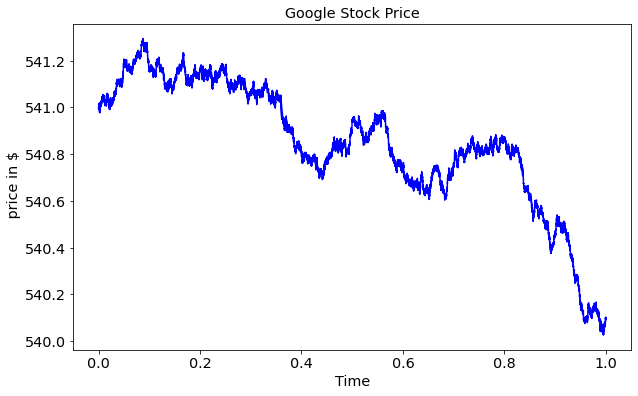

In [261]:
plt.figure(figsize=(10, 6))
plt.plot(tt, S, 'b', lw=1.5)
plt.xlabel('Time')
plt.ylabel(' price in $')
plt.title('Google Stock Price')

## Liqudation of  500,000 shares using Market Order 

The following code computes the optimal speed to trade at  𝜈∗𝑡  and inventory along the optimal strategy  𝑄𝜈∗𝑡 .

### Trading and inventory speed with low price impact

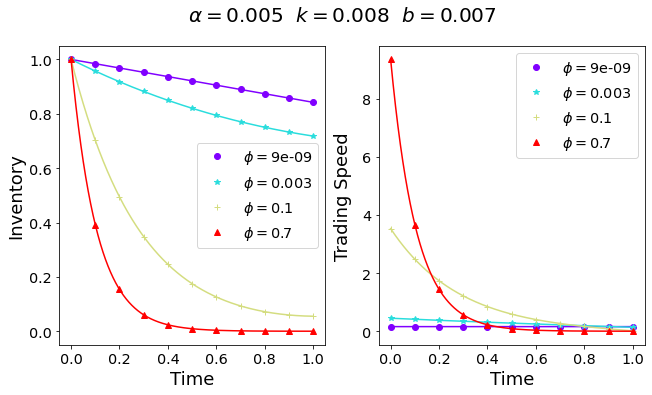

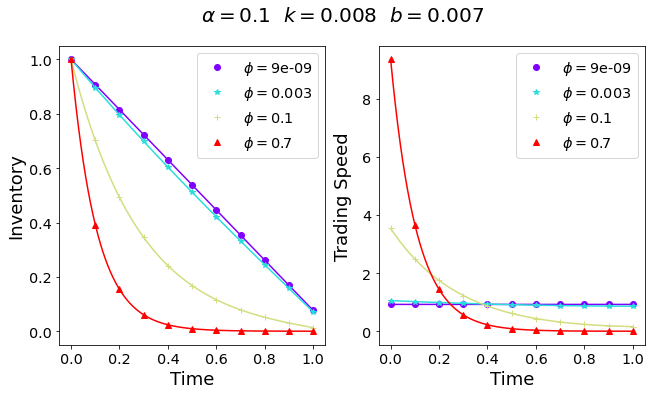

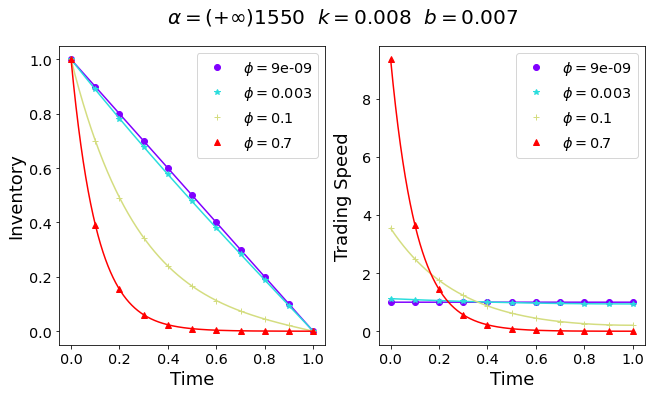

In [275]:
lppi_helpers.plot_inventory_trading_speed(alpha_low, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = $" + str(alpha_low) + "  $ k =  $" + str(k) +  "  $ b =  $" + str(b) )
lppi_helpers.plot_inventory_trading_speed(alpha_med, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = $" + str(alpha_med) + "  $ k =  $" + str(k) +  "  $ b =  $" + str(b) )
lppi_helpers.plot_inventory_trading_speed(alpha_high, myphi, symb, t, tt, T, b, k, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = (+\infty)$" +   str(alpha_high) + "  $ k =  $" + str(k) +  "  $ b =  $" + str(b) )

### Trading and inventory speed with low price impact 

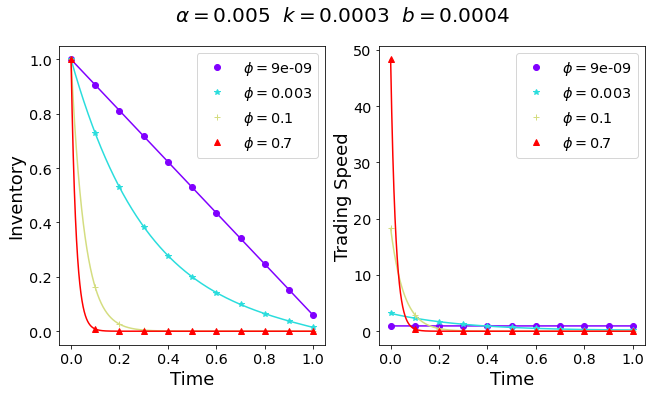

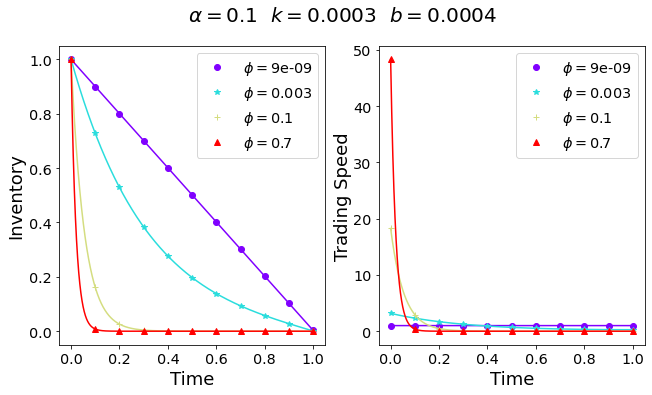

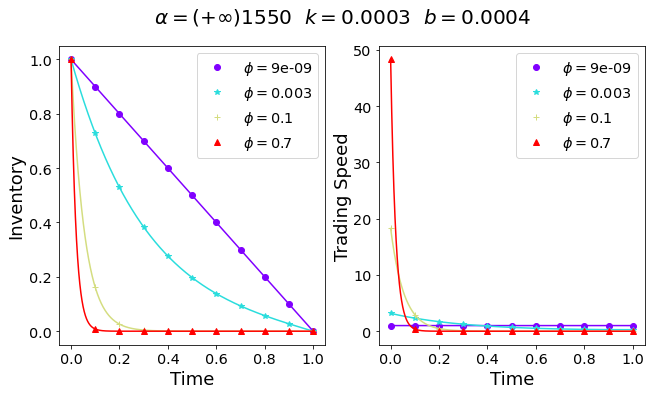

In [273]:
lppi_helpers.plot_inventory_trading_speed(alpha_low, myphi, symb, t, tt, T, b_2, k_2, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = $" + str(alpha_low) + "  $ k =  $" + str(k_2) +  "  $ b =  $" + str(b_2) )
lppi_helpers.plot_inventory_trading_speed(alpha_med, myphi, symb, t, tt, T, b_2, k_2, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = $" + str(alpha_med) + "  $ k =  $" + str(k_2) +  "  $ b =  $" + str(b_2) )
lppi_helpers.plot_inventory_trading_speed(alpha_high, myphi, symb, t, tt, T, b_2, k_2, [r"$\phi = $" + str(i) for i in myphi], main=r"$\alpha = (+\infty)$" +   str(alpha_high) + "  $ k =  $" + str(k_2) +  "  $ b =  $" + str(b_2) )

In terms of price impact, this analysis help to conclude if the price impact is very low, then we can execute the trade quickly with large volume but if the price impact is very high, then we need to find the optimal trading time and trading volme. 

In terms of penalty , if inventory penalty is high then try to liquidate the shares faster and if terminal penalty also higher then don't keep the shares to execute till end. On the other hand if terminal penalty and inventory penalty is low then it's okay to leave some shares unexecuted and bear the penalty 